## Setup and Import Libraries

In [2]:
import os
import umap
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from openai import OpenAI
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from utils import load_chroma, word_wrap, project_embeddings
from dotenv import load_dotenv

import warnings
warnings.filterwarnings('ignore')

In [3]:
load_dotenv()

True

In [4]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [5]:
openai_client = OpenAI()

## Projecting Embeddings

In [6]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(
    filename='data/microsoft_annual_report_2022.pdf',
    collection_name='microsoft_annual_report_2022', 
    embedding_function=embedding_function
)
chroma_collection.count()

349

In [7]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 349/349 [00:04<00:00, 72.39it/s] 


## Creating a dataset

In [8]:
def generate_queries(model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
            "Suggest 10 to 15 short questions that are important to ask when analyzing an annual report. "
            "Do not output any compound questions (questions with multiple sentences or conjunctions)."
            "Output each question on a separate line divided by a newline."
        },
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [9]:
generated_queries = generate_queries()
for query in generated_queries:
    print(query)

1. What is the company's revenue trend over the past few years?
2. What are the major cost drivers impacting the company's profitability?
3. How is the company managing its debt levels and interest payments?
4. What is the company's current cash position and liquidity ratios?
5. Are there any significant changes in the company's inventory levels?
6. What is the trend in the company's operating expenses as a percentage of revenue?
7. How has the company's net income been affected by tax expenses?
8. What are the key drivers of the company's growth or contraction in earnings?
9. Are there any potential risks or uncertainties disclosed in the footnotes?
10. What is the company's dividend policy and recent dividend history?
11. What are the key performance indicators (KPIs) used by the company to measure success?
12. How does the company compare to its competitors in terms of key financial metrics?
13. Are there any related party transactions that could impact the company's financial posit

In [10]:
results = chroma_collection.query(query_texts=generated_queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

In [11]:
def evaluate_results(query, statement, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
            "For the given query, evaluate whether the following satement is relevant."
            "Output only 'yes' or 'no'."
        },
        {
            "role": "user",
            "content": f"Query: {query}, Statement: {statement}"
        }
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=1
    )
    
    content = response.choices[0].message.content
    if content == "yes":
        return 1
    return -1

In [12]:
retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

In [13]:
adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []

In [14]:
for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document))

100%|██████████| 15/15 [01:41<00:00,  6.76s/it]


In [15]:
len(adapter_labels)

150

In [16]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

In [17]:
dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

## Setting up the Model

In [18]:
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)

In [19]:
def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

In [20]:
# Initialize the adaptor matrix
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

In [21]:
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()

100%|██████████| 100/100 [00:04<00:00, 23.27it/s]


In [22]:
print(f"Best loss: {min_loss.detach().numpy()}")

Best loss: 0.5546113848686218


In [23]:
test_vector = torch.ones((mat_size,1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

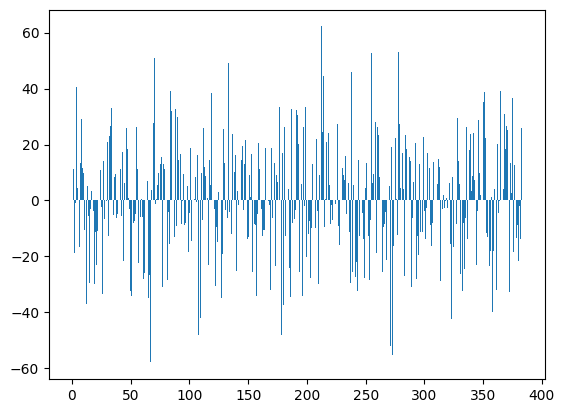

In [24]:
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()

In [25]:
query_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

100%|██████████| 15/15 [00:00<00:00, 436.45it/s]


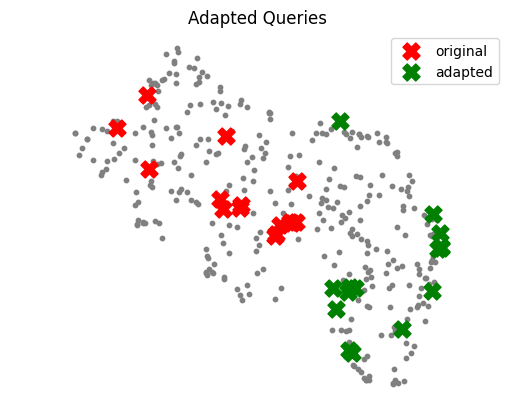

In [26]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()